In [2]:
%load_ext autotime
%matplotlib inline
import sys
# sys.path.append('/Users/pradap/Documents/Research/Python-Package/anhaid/py_entitymatching/')
sys.path.append('/scratch/pradap/python-work/anhaidgroup/py_entitymatching/')

In [3]:
import py_entitymatching as em
import py_stringsimjoin as ssj
import profiler
import pandas as pd
import qgrid

time: 787 ms


In [4]:
A = em.read_csv_metadata('./ORIG_DBLP_ACM/dblp_sim_title_rem_title_auth_swapped.csv', key='id', dtype=str)
B = em.read_csv_metadata('./ORIG_DBLP_ACM/acm_sim_title_rem_perturb_year.csv', key='id', dtype=str)

time: 16.2 ms


In [5]:
len(A), len(B)

(1800, 1813)

time: 70.7 ms


In [6]:
A.head(2)

,id,title,authors,venue,year
0,conf/sigmod/Team95a,Paradise: A Database System for GIS Applications,Paradise Team,SIGMOD Conference,1995
1,conf/sigmod/BunemanDHS96,A Query Language and Optimization Techniques for Unstructured Data,"Gerd G. Hillebrand, Peter Buneman, Susan B. Davidson, Dan Suciu",SIGMOD Conference,1996


time: 62.7 ms


In [7]:
B.head(2)

,id,title,authors,venue,year
0,304201,An efficient bitmap encoding scheme for selection queries,"Chee-Yong Chan, Yannis E. Ioannidis",International Conference on Management of Data,1999
1,672964,Integrating a Structured-Text Retrieval System with an Object-Oriented Database System,"Tak W. Yan, Jurgen Annevelink",Very Large Data Bases,1994


time: 72 ms


In [8]:
A1, B1 = em.down_sample(A, B, 300, 1, show_progress=False)
len(A1), len(B1)

(293, 300)

time: 428 ms


Number of unique values: 5
Number of missing values: 0

Unique values: 
['ACM Trans. Database Syst.', 'SIGMOD Conference', 'SIGMOD Record', 'VLDB', 'VLDB J.']

Frequency plot:



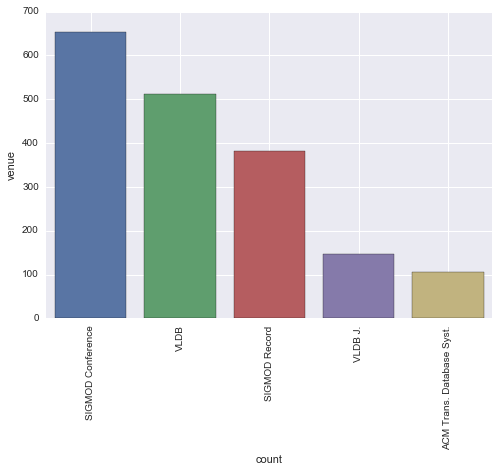

time: 211 ms


In [9]:
# Blocking
profiler.profile_table(A, 'venue')

Number of unique values: 5
Number of missing values: 0

Unique values: 
['ACM SIGMOD Record', 'ACM Transactions on Database Systems (TODS)', 'International Conference on Management of Data', 'The VLDB Journal — The International Journal on Very Large Data Bases', 'Very Large Data Bases']

Frequency plot:



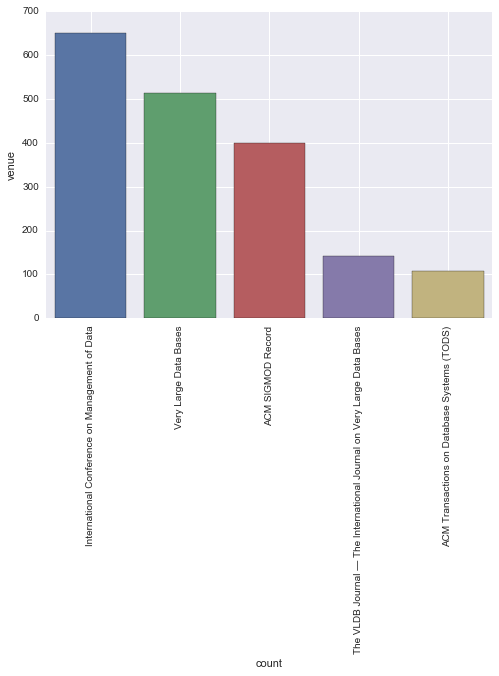

time: 222 ms


In [10]:
profiler.profile_table(B, 'venue')

Number of unique values: 10
Number of missing values: 0

Unique values: 
['1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003']

Frequency plot:



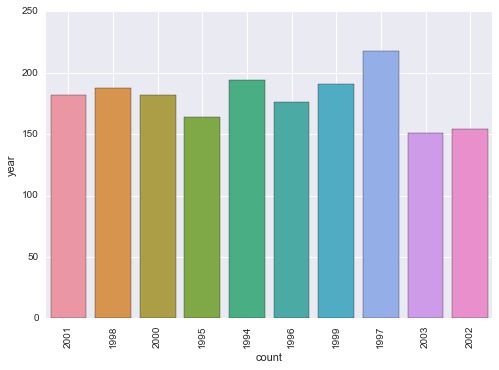

time: 228 ms


In [11]:
profiler.profile_table(A, 'year')

Number of unique values: 10
Number of missing values: 0

Unique values: 
['1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003']

Frequency plot:



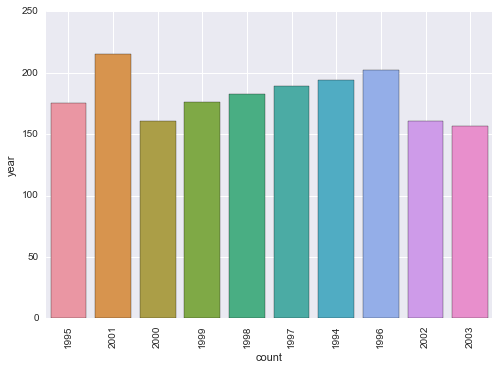

time: 235 ms


In [12]:
profiler.profile_table(B, 'year')

In [13]:
# Plan
### Plan

### A, B -- AttrEquivalnce blocker [year]--------------------------| Candidate set

time: 797 µs


In [14]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()
# Block tables using 'year' attribute : same year include in candidate set
C1 = ab.block_tables(A, B, 'year', 'year', 
                     l_output_attrs=['title', 'authors', 'year'],
                     r_output_attrs=['title', 'authors', 'year']
                    )

time: 155 ms


In [15]:
# Debug blocking output

# check whether the current blocking method has dropped a lot of potential matches
dbg = em.debug_blocker(C1, A, B)

time: 1.26 s


In [16]:
em.view_table(dbg)

time: 17 s


In [17]:
# Revised blocking plan

# A, B -- AttrEquivalnce blocker [year] --------------------|
#                                                           |---> candidate set
# A, B -- Overlap blocker [title]---------------------------|

time: 943 µs


In [18]:
profiler.profile_table(A, 'title')

Number of unique values: 1799
Number of missing values: 0
time: 94.8 ms


In [19]:
profiler.profile_table(B, 'title')

Number of unique values: 1803
Number of missing values: 0
time: 76.5 ms


In [20]:
ob = em.OverlapBlocker()
C2 = ob.block_tables(A, B, 'title', 'title', show_progress=False, overlap_size=1)

time: 1.1 s


In [21]:
C = em.combine_blocker_outputs_via_union([C1, C2])

time: 827 ms


In [22]:
# debug blocker
# check again with the updated blocking pipleline
dbg = em.debug_blocker(C, A, B)

time: 1.75 s


In [23]:
em.view_table(dbg)

time: 2.28 s


In [24]:
# Sampling and labeling the candidate set
S = em.sample_table(C, 450)

time: 217 ms


In [25]:
#L = em.label_table(S, 'gold')

time: 526 µs


In [26]:
# Load the pre-labeled data
L = em.read_csv_metadata('./ORIG_DBLP_ACM/labeled_data_dblp_acm_after_monkey_tricks.csv', ltable=A, rtable=B, dtype={'rtable_id':str})
# Display the number of rows in the labaled data set
len(L)

450

time: 104 ms


In [27]:
L.dtypes

_id           int64
ltable_id    object
rtable_id    object
label         int64
dtype: object

time: 84.6 ms


In [28]:
# Split the labeled data into development and evaluation set
development_evaluation = em.split_train_test(L, train_proportion=0.7)
development =  development_evaluation['train']
evaluation = development_evaluation['test']
len(development), len(evaluation)

(315, 135)

time: 114 ms


In [29]:
# Create a set of ML-matchers
dt = em.DTMatcher(name='DecisionTree')
svm = em.SVMMatcher(name='SVM')
rf = em.RFMatcher(name='RF')
nb = em.NBMatcher(name='NB')
lg = em.LogRegMatcher(name='LogReg')
ln = em.LinRegMatcher(name='LinReg')

time: 77.6 ms


In [30]:
# Generate features
feature_table = em.get_features_for_matching(A, B)

time: 162 ms


In [62]:
# List the names of the features generated
feature_table['feature_name']

0                          id_id_lev_dist
1                           id_id_lev_sim
2                               id_id_jar
3                               id_id_jwn
4                               id_id_exm
5                   id_id_jac_qgm_3_qgm_3
6             title_title_jac_qgm_3_qgm_3
7         title_title_cos_dlm_dc0_dlm_dc0
8                         title_title_mel
9                    title_title_lev_dist
10                    title_title_lev_sim
11        authors_authors_jac_qgm_3_qgm_3
12    authors_authors_cos_dlm_dc0_dlm_dc0
13                    authors_authors_mel
14               authors_authors_lev_dist
15                authors_authors_lev_sim
16                     year_year_lev_dist
17                      year_year_lev_sim
18                          year_year_jar
19                          year_year_jwn
20                          year_year_exm
21              year_year_jac_qgm_3_qgm_3
Name: feature_name, dtype: object

time: 3.5 ms


In [63]:
###### Select the year related features
feature_subset_iter1 = feature_table[6:10]

time: 1.13 ms


In [54]:
# feature_subset_iter1

time: 555 µs


In [64]:
# Extract feature vectors
feature_vectors_dev = em.extract_feature_vecs(development, 
                            feature_table=feature_subset_iter1, 
                            attrs_after='label',
                            show_progress=False) 

time: 285 ms


In [65]:
# Display first few rows
feature_vectors_dev.head(3)

,_id,ltable_id,rtable_id,title_title_jac_qgm_3_qgm_3,title_title_cos_dlm_dc0_dlm_dc0,title_title_mel,title_title_lev_dist,label
142,142,conf/vldb/RastogiS98,671183,0.000000,0.000000,0.463510,60.0,1
28,28,journals/vldb/BerchtoldKK97,276353,0.053333,0.111803,0.648553,64.0,0
400,400,conf/sigmod/IoannidisP95,671527,0.135593,0.000000,0.595217,58.0,0


time: 10.8 ms


In [66]:
# Check if the feature vectors contain missing values
# A return value of True means that there are missing values
feature_vectors_dev.isnull().values.any()

False

time: 3.44 ms


In [71]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, nb, lg, ln], table=feature_vectors_dev, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=10,
        target_attr='label', metric='precision')

time: 252 ms


In [72]:
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x7f5745bee048>,10,0.950000,1.000000,0.842105,0.916667,1.000000,0.900000,0.904762,1.000000,0.809524,0.944444,0.926750
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x7f5745bee588>,10,0.857143,0.866667,0.950000,1.000000,0.958333,0.954545,0.882353,1.000000,0.900000,1.000000,0.936904
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x7f5745bee0b8>,10,1.000000,0.900000,1.000000,0.863636,0.954545,1.000000,0.950000,1.000000,0.937500,0.857143,0.946282
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x7f5745bee438>,10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x7f5745beec88>,10,1.000000,0.941176,1.000000,1.000000,1.000000,0.952381,1.000000,0.888889,1.000000,1.000000,0.978245
5,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x7f5745bee9b0>,10,0.900000,1.000000,1.000000,1.000000,0.812500,1.000000,1.000000,0.933333,1.000000,0.952381,0.959821


time: 18.8 ms


In [73]:
## Split feature vectors into train and test
train_test = em.split_train_test(feature_vectors_dev, train_proportion=0.5)
train = train_test['train']
test = train_test['test']

time: 6.34 ms


In [74]:
# Debug decision tree using GUI
em.vis_debug_rf(rf, train, test, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        target_attr='label')

time: 13.1 s
